In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

전처리
1. 결측값은 KNN
2. 이상치제거 없음
3. 라벨인코딩, 원핫인코딩(성별, 결혼상태)
4. standard scaling
5. 나이는 범주화하지 않기

#### Data Load & 데이터 확인

In [3]:
import warnings
warnings.filterwarnings(action='ignore') 

In [170]:
DATA_DIR = "../data/"

In [201]:
df = pd.read_csv(DATA_DIR+"BankChurners.csv").iloc[:, 1:-2]
df_original = df.copy()

In [38]:
print(f"shape = {df.shape}")
df.columns.to_list()

shape = (10127, 20)


['Attrition_Flag',
 'Customer_Age',
 'Gender',
 'Dependent_count',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

#### 분포도 분석

- dependent variables(y) = Attrition_Flag

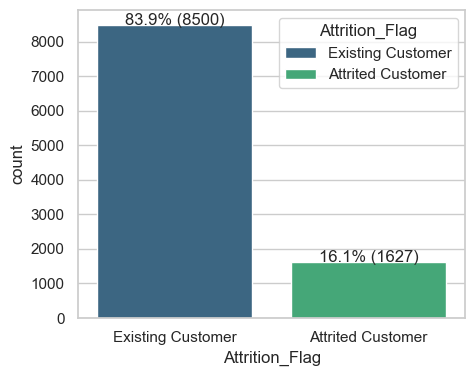

In [40]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 4))
ax = sns.countplot(data=df, x='Attrition_Flag', palette='viridis')

# 퍼센트 표시
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f"{percentage} ({int(p.get_height())})", (x, y), size=12, ha='center')

# 범례 표시
plt.legend(labels=['Existing Customer', 'Attrited Customer'], title="Attrition_Flag", loc='upper right')

plt.show()

종속변인(y)는 유지고객 83.9%, 이탈 고객 16.1%로 imbalance

- categorical variables

['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


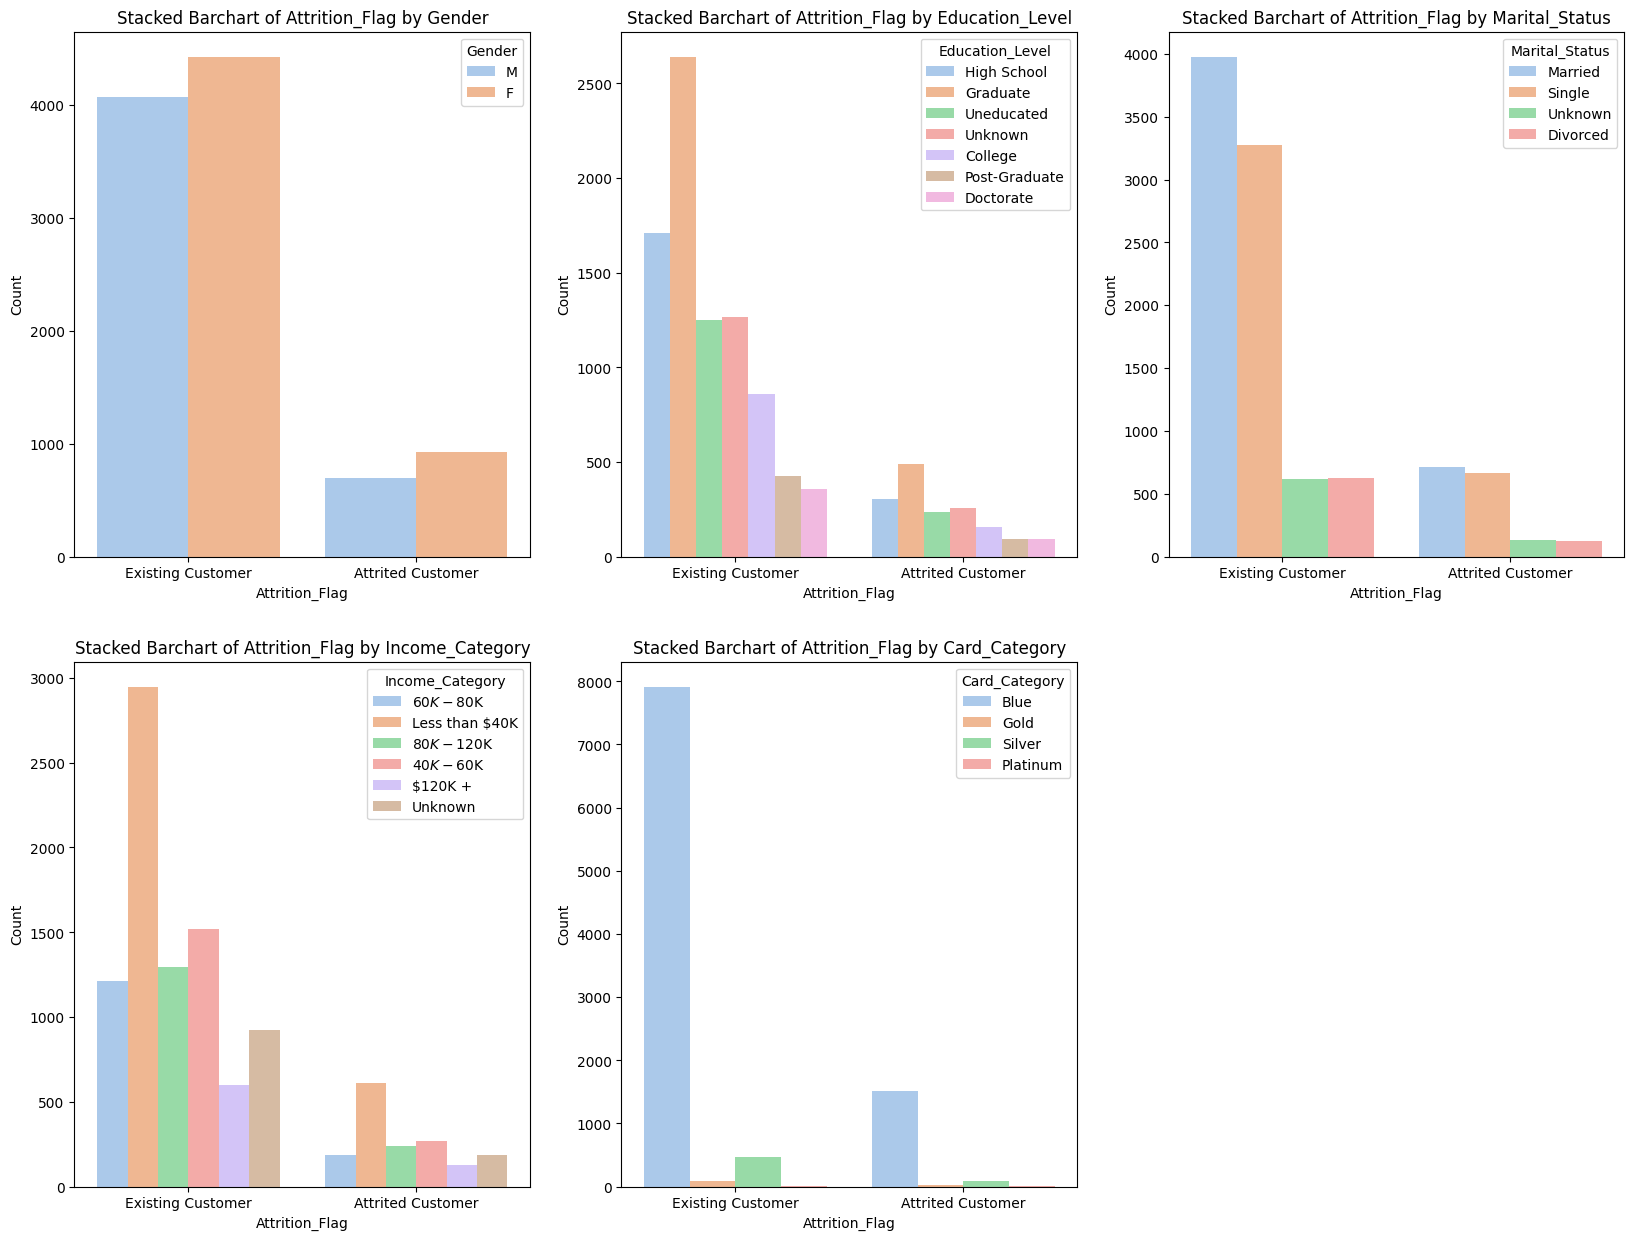

In [178]:
# 범주형 변수의 목록
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns[1:]
print(categorical_columns.to_list())

# 범주형 변수의 정렬 순서 설정
education_order = ["Doctorate", "Post-Graduate", "Graduate", "College", "High School", "Uneducated", "Unknown"]
marital_status_order = ["Married", "Single", "Divorced", "Unknown"]
income_order = ["$120K +", "$80K - $120K", "$60K - $80K", "$40K - $60K", "Less than $40K", "Unknown"]
card_order = ["Platinum", "Gold", "Silver", "Blue"]

# 서브플롯 생성
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
fig.subplots_adjust(hspace=0.2)

# 각 범주형 변수에 대한 stacked barplot 그리기
for i, column in enumerate(categorical_columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    sns.countplot(data=df, x='Attrition_Flag', hue=column, ax=ax, palette="pastel")
    ax.set_title(f"Stacked Barchart of Attrition_Flag by {column}")
    ax.set_xlabel("Attrition_Flag")
    ax.set_ylabel("Count")
    ax.legend(title=column)
    
# 마지막 서브플롯 삭제 (만약 범주형 변수가 2개 미만일 경우)
if len(categorical_columns) < 6:
    fig.delaxes(axes[1, 2])

plt.show()

- 수입이 낮을수록 카드사 고객등급이 낮은지 확인

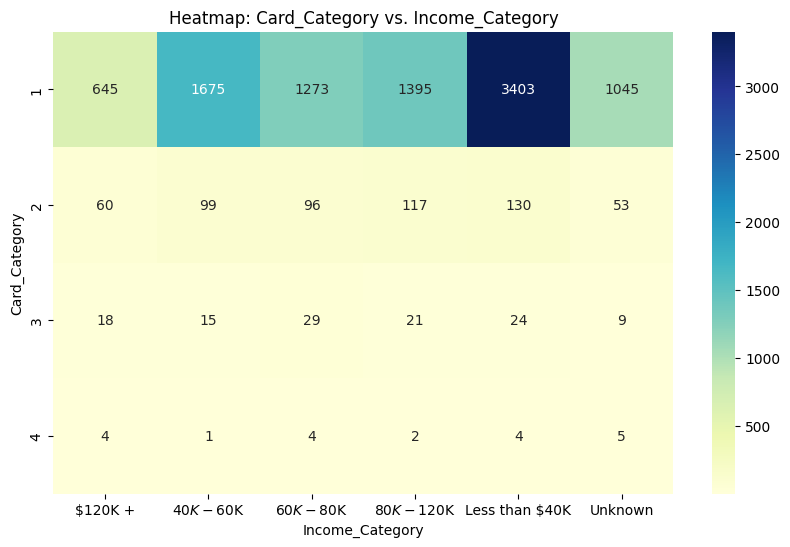

In [190]:
income_grade = pd.read_pickle(DATA_DIR + 'base_dataset_before_std.pkl') #불러오기

# 'Card_Category' 데이터를 1, 2, 3, 4로 변환
category_mapping = {'Blue': 1, 'Silver': 2, 'Gold': 3, 'Platinum': 4}
df['Card_Category'] = df['Card_Category'].map(category_mapping)

# 두 범주형 변수 간의 교차표 생성
cross_tab = pd.crosstab(df['Card_Category'], df['Income_Category'])

# 히트맵으로 교차표 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Heatmap: Card_Category vs. Income_Category')
plt.show()

In [202]:
df_attr = df[df['Attrition_Flag'] == 'Attrited Customer']
df_attr.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

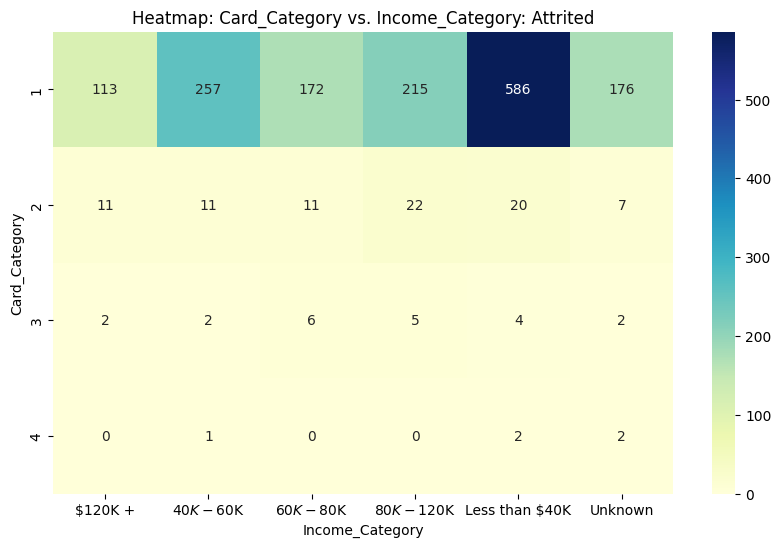

In [203]:
# 'Card_Category' 데이터를 1, 2, 3, 4로 변환
category_mapping = {'Blue': 1, 'Silver': 2, 'Gold': 3, 'Platinum': 4}
df_attr['Card_Category'] = df_attr['Card_Category'].map(category_mapping)

# 두 범주형 변수 간의 교차표 생성
cross_tab = pd.crosstab(df_attr['Card_Category'], df_attr['Income_Category'])

# 히트맵으로 교차표 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Heatmap: Card_Category vs. Income_Category: Attrited')
plt.show()

- numerical variables

['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


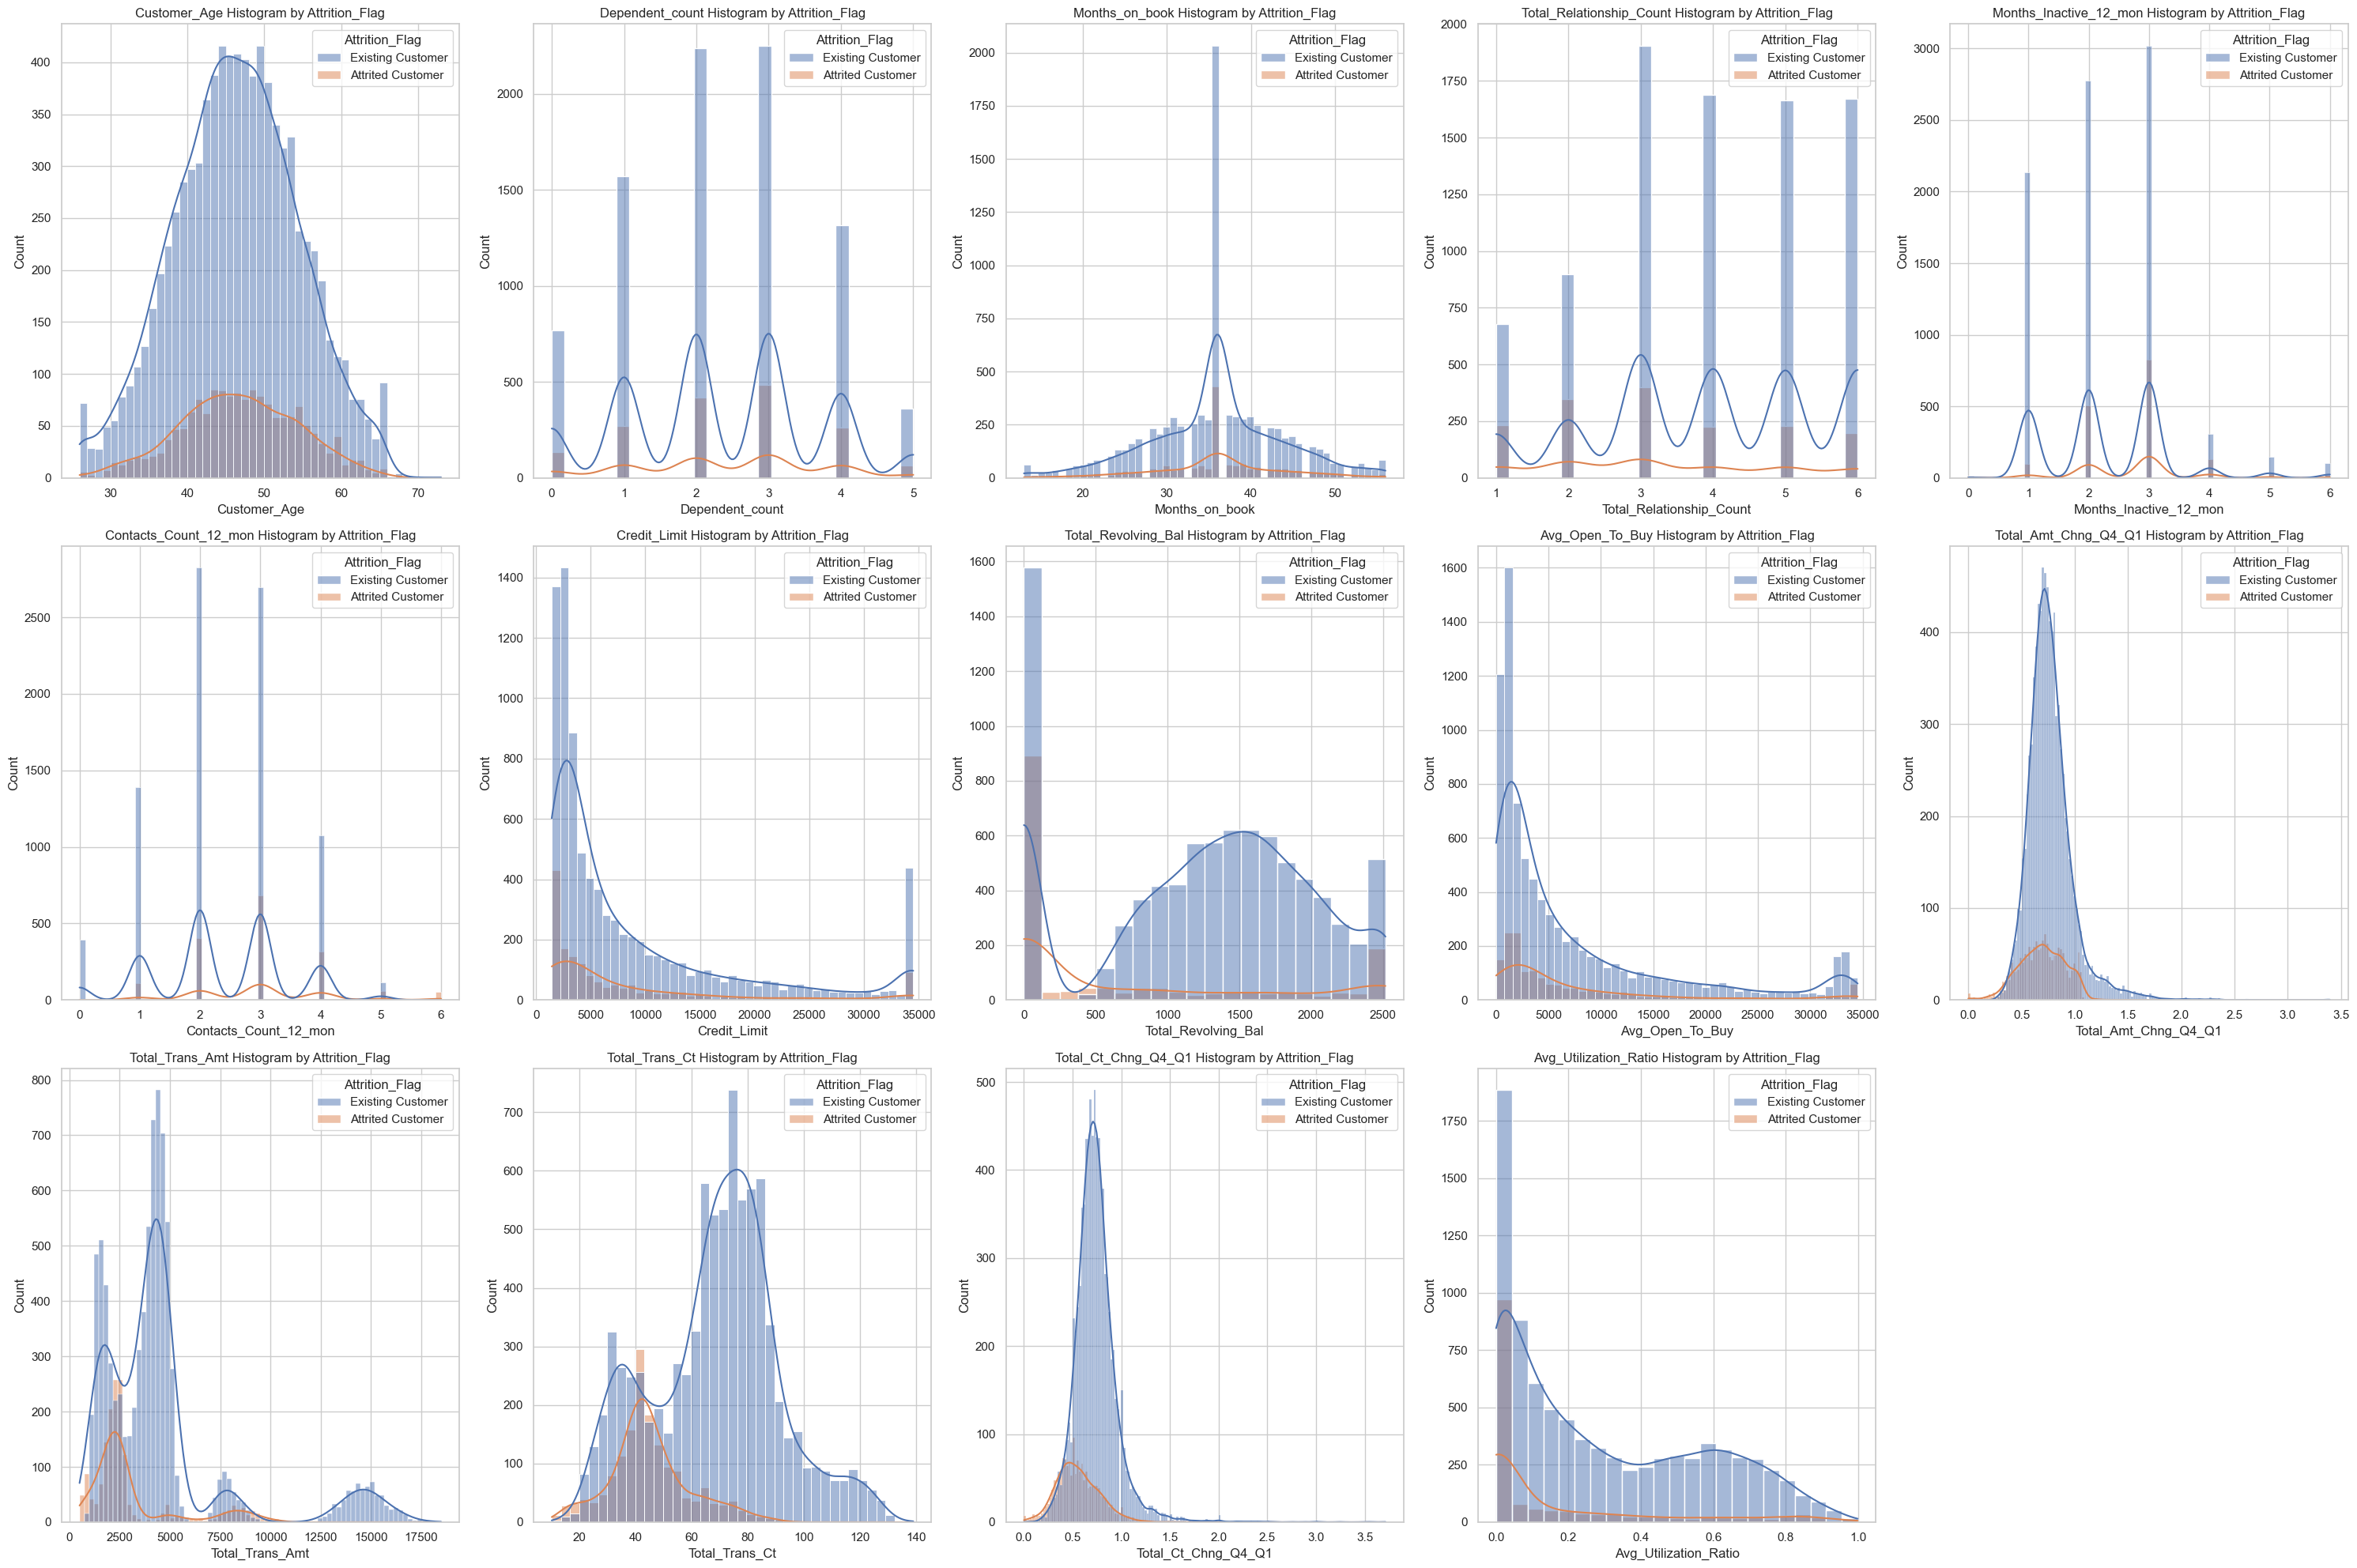

In [44]:
numerical_columns = df.select_dtypes(include=['number']).columns
print(numerical_columns.to_list())

num_rows, num_cols = 3, 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 20))

# numerical 변수 별로 histoplot 그리기
for i, column in enumerate(numerical_columns):
    row, col = i // num_cols, i % num_cols
    sns.histplot(data=df, x=column, hue="Attrition_Flag", kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'{column} Histogram by Attrition_Flag')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Count')

# 공백 subplot 숨기기
for i in range(len(numerical_columns), num_rows * num_cols):
    row, col = i // num_cols, i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

다른 변수들은 비슷한 분포도를 보이나, Total_Trans_Ct(거래 횟수)는 유지 고객 대비 이탈 고객이 더 낮은 경향성을 보임

#### Multicollinearity(다중공선성) 제거

In [22]:
# Credit_Limit 과 Avg_Open_To_Buy는 강한 상관관계가 있으므로 open to buy 열 삭제
df = df.drop(['Avg_Open_To_Buy'], axis=1)

In [23]:
df.shape

(10127, 19)

#### Categorical Variables Label Encoding

- dependent variable label encoding (유지 고객:0, 이탈 고객:1)

In [16]:
df['Attrition_Flag'] = df['Attrition_Flag'].apply(lambda x: 0 if x == 'Existing Customer' else 1)

- Unknown이 있는 컬럼(Education_Level, Marital_Status, Income_Category)은 KNN으로 결측치 대체
- (전체 고객을 대상으로 이탈 관리 및 마케팅 집행 여부를 분석하기 위해)

In [24]:
df['Card_Category'].value_counts()

Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: count, dtype: int64

In [25]:
# Label Encoding
gender = {'M': 0, 'F': 1}
df['Gender']=df['Gender'].map(gender)

marital_status = {'Married': 1,'Single': 2, 'Divorced': 3}
df['Marital_Status'] = df['Marital_Status'].map(marital_status)

education_level = {'Uneducated': 1,'High School': 2, 'Graduate': 3, 'College': 4, 'Post-Graduate': 5, 'Doctorate': 6}
df['Education_Level'] = df['Education_Level'].map(education_level)

income_cat = {'Less than $40K': 1,'$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4, '$120K +': 5}
df['Income_Category'] = df['Income_Category'].map(income_cat)

card_cat = {'Blue': 1, 'Silver': 2, 'Gold': 3, 'Platinum': 4}
df['Card_Category'] = df['Card_Category'].map(card_cat)


In [55]:
df = df.replace({'Unknown': None})
df.isnull().sum()

Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

In [154]:
cat_cols = None

for i in ['Marital_Status', 'Education_Level', 'Income_Category']:
    # print(df[['Attrition_Flag', i]].value_counts(dropna=False))
    curr = df[['Attrition_Flag', i]]
    curr[i] = curr[i].apply(lambda x: 1 if not pd.isna(x) else 0)
    # print(curr.value_counts())
    
    if cat_cols is None:
        cat_cols = curr.value_counts()
    else:
        cat_cols = pd.concat([cat_cols, curr.value_counts()], axis=1)


cat_cols.columns = ['Marital_Status', 'Education_Level', 'Income_Category']
cat_cols.index = ['Existing Customer - Answered', 'Attrited Customer - Answered', 'Existing Customer - Not Answered', 'Attrited Customer - Not Answered']
cat_cols
    


,Marital_Status,Education_Level,Income_Category
Existing Customer - Answered,7880,7237,7575
Attrited Customer - Answered,1498,1371,1440
Existing Customer - Not Answered,620,1263,925
Attrited Customer - Not Answered,129,256,187


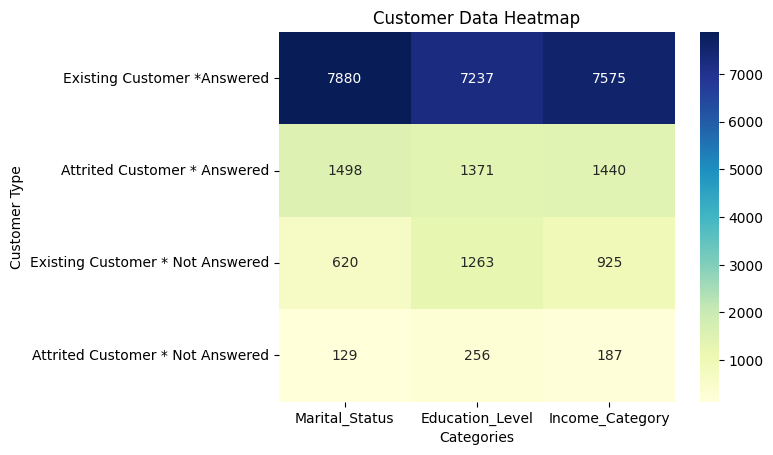

In [167]:
# 행과 열의 레이블 정의
index_labels = ["Existing Customer *Answered", "Attrited Customer * Answered", "Existing Customer * Not Answered", "Attrited Customer * Not Answered"]
column_labels = ["Marital_Status", "Education_Level", "Income_Category"]

# 데이터와 레이블을 사용하여 히트맵 그리기
sns.heatmap(cat_cols, annot=True, fmt='d', cmap="YlGnBu", xticklabels=column_labels, yticklabels=index_labels)
plt.xlabel('Categories')
plt.ylabel('Customer Type')
plt.title('Customer Data Heatmap')
plt.show()

In [20]:
# imputing instance
imputer = KNNImputer(n_neighbors=7)
cols_to_impute = ['Marital_Status', 'Education_Level', 'Income_Category']

# Split the data and fit
X = df.drop(['Attrition_Flag'], axis=1)
y = df['Attrition_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
X_train[cols_to_impute]=imputer.fit_transform(X_train[cols_to_impute])

X_test[cols_to_impute]=imputer.transform(X_test[cols_to_impute])

In [21]:
train_tot = pd.concat([X_train, y_train], axis=1)
test_tot = pd.concat([X_test, y_test], axis=1)
train_tot.sort_index(ascending=True, inplace=True)
test_tot.sort_index(ascending=True, inplace=True)

df2 = pd.concat([train_tot, test_tot], axis=0)
df2.sort_index(ascending=True, inplace=True)
print(f"{df.shape = }, {df2.shape = }")

df.shape = (10127, 19), df2.shape = (10127, 19)


In [22]:
# KNN 예측값 실수를 반올림하여 정수화
for col in cols_to_impute:
    df2[col] = np.round(df2[col]).astype('int')

df2[cols_to_impute].head()

,Marital_Status,Education_Level,Income_Category
0,1,2,3
1,2,3,1
2,1,3,4
3,1,2,1
4,1,1,3


- level(대소) 구분이 불가능한 categorical 변수만 one-hot encoding

In [23]:
to_one_hot = ['Gender', 'Marital_Status']

In [24]:
df3=pd.get_dummies(df2, columns=to_one_hot, drop_first=False)
df3.shape

(10127, 22)

In [25]:
df3.columns

Index(['Customer_Age', 'Dependent_count', 'Education_Level', 'Income_Category',
       'Card_Category', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
       'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Attrition_Flag', 'Gender_0', 'Gender_1', 'Marital_Status_1',
       'Marital_Status_2', 'Marital_Status_3'],
      dtype='object')

In [26]:
to_one_hot

['Gender', 'Marital_Status']

In [27]:
# column 이름 재설정 후 one-hot encoding 이전 컬럼 제거
new_col_names = {
    'Gender_0': 'Gender_Male',
    'Marital_Status_1': 'Marital_Status_Uneducated',
    'Marital_Status_2': 'Marital_Status_Single',
    'Marital_Status_3': 'Marital_Status_Divorced'
}
df3 = df3.rename(columns=new_col_names)
df3.drop(columns='Gender_1', axis=1, inplace=True)
df3.columns

Index(['Customer_Age', 'Dependent_count', 'Education_Level', 'Income_Category',
       'Card_Category', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
       'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Attrition_Flag', 'Gender_Male', 'Marital_Status_Uneducated',
       'Marital_Status_Single', 'Marital_Status_Divorced'],
      dtype='object')

In [28]:
df2.shape, df3.shape
# 19개 col중 Gender은 1->1 대체, Marital_Status는 1->3 대체로 최종 col 수는 19+2 = 21

((10127, 19), (10127, 21))

In [29]:
# label(y) Attrition_Flag 맨 오른쪽으로 위치 변경
new_col_order = [col for col in df3.columns if col != 'Attrition_Flag'] + ['Attrition_Flag']
df3 = df3[new_col_order]

In [30]:
df3.columns, df3.shape

(Index(['Customer_Age', 'Dependent_count', 'Education_Level', 'Income_Category',
        'Card_Category', 'Months_on_book', 'Total_Relationship_Count',
        'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
        'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
        'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
        'Gender_Male', 'Marital_Status_Uneducated', 'Marital_Status_Single',
        'Marital_Status_Divorced', 'Attrition_Flag'],
       dtype='object'),
 (10127, 21))

#### Features Standardization

##### Standard Scaler

- x 값의 가중치를 동일하게 만들기 위해 standard scaler로 정규화
- one-hot encoded 값과 y 값은 scaling 불필요
- 연속형 변수만 처리

In [31]:
scaler = StandardScaler()
no_need_std = ['Gender_Male', 'Marital_Status_Uneducated', 'Marital_Status_Single', 'Marital_Status_Divorced', 'Attrition_Flag']
scaler.fit_transform(df3.drop(no_need_std, axis=1))
scaled_features = scaler.transform(df3.drop(no_need_std, axis=1))

In [35]:
scaled_features = pd.DataFrame(scaled_features, columns=df3.columns[:-5])
df_final = pd.concat([scaled_features, df3.iloc[:, -5:]], axis=1)
df_final.head(25)

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_Male,Marital_Status_Uneducated,Marital_Status_Single,Marital_Status_Divorced,Attrition_Flag
0,-0.165406,0.503368,-0.657196,0.491178,-0.250587,0.384621,0.763943,-1.327136,0.492404,0.446622,...,2.623494,-0.959707,-0.973895,3.834003,-0.775882,1,1,0,0,0
1,0.333570,2.043199,0.159721,-1.053353,-0.250587,1.010715,1.407306,-1.327136,-0.411616,-0.041367,...,3.563293,-0.916433,-1.357340,12.608573,-0.616276,0,0,1,0,0
2,0.583058,0.503368,0.159721,1.263444,-0.250587,0.008965,0.120579,-1.327136,-2.219655,-0.573698,...,8.367214,-0.740982,-1.911206,6.807864,-0.997155,1,1,0,0,0
3,-0.789126,1.273283,-0.657196,-1.053353,-0.250587,-0.241473,-0.522785,1.641478,-1.315636,-0.585251,...,2.942843,-0.951758,-1.911206,6.807864,1.759686,0,1,0,0,0
4,-0.789126,0.503368,-1.474113,0.491178,-0.250587,-1.869317,0.763943,-1.327136,-2.219655,-0.430877,...,6.455682,-1.056263,-1.570365,7.509325,-0.997155,1,1,0,0,0
5,-0.290150,-0.266547,0.159721,-0.281087,-0.250587,0.008965,-0.522785,-1.327136,-0.411616,-0.508559,...,2.810542,-0.976192,-1.740786,0.561915,0.130973,1,1,0,0,0
6,0.583058,1.273283,0.159721,2.035710,5.741599,1.261152,1.407306,-1.327136,0.492404,2.848054,...,5.543256,-0.904952,-1.442550,0.041070,-0.757745,1,1,0,0,0
7,-1.787077,-1.806378,-0.657196,0.491178,2.745506,-1.118005,-1.166148,-0.337598,-0.411616,2.250034,...,6.587984,-0.843721,-1.229525,0.007467,-0.823039,1,1,0,0,0
8,-1.163358,0.503368,-1.474113,0.491178,-0.250587,0.008965,0.763943,-0.337598,-2.219655,1.509634,...,11.838993,-0.899064,-1.740786,1.973239,-0.587256,1,0,1,0,0
9,0.208826,-0.266547,0.159721,1.263444,-0.250587,0.008965,1.407306,0.651940,0.492404,0.332740,...,3.485737,-0.872275,-1.399945,0.713129,-0.474806,1,0,1,0,0


#### 데이터 pkl export

In [36]:
# dataset export (피클로 파이썬 pandas dataframe 객체 그대로 저장)
df3.to_pickle(DATA_DIR + 'base_dataset_before_std.pkl')
df_final.to_pickle(DATA_DIR + 'base_dataset_numerical_std.pkl')

# 기존 base_dataset_standardized.pkl은 one-hot encoding도 standardize 한 문제점이 있어서
# base_dataset_numerical_std.pkl에서 정상적으로 연속형 변수만 standardize하도록 수정함

In [37]:
# 피클 파일에서 pandas dataframe 객체 복원
test = pd.read_pickle(DATA_DIR + 'base_dataset_numerical_std.pkl') #불러오기
test

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_Male,Marital_Status_Uneducated,Marital_Status_Single,Marital_Status_Divorced,Attrition_Flag
0,-0.165406,0.503368,-0.657196,0.491178,-0.250587,0.384621,0.763943,-1.327136,0.492404,0.446622,...,2.623494,-0.959707,-0.973895,3.834003,-0.775882,1,1,0,0,0
1,0.333570,2.043199,0.159721,-1.053353,-0.250587,1.010715,1.407306,-1.327136,-0.411616,-0.041367,...,3.563293,-0.916433,-1.357340,12.608573,-0.616276,0,0,1,0,0
2,0.583058,0.503368,0.159721,1.263444,-0.250587,0.008965,0.120579,-1.327136,-2.219655,-0.573698,...,8.367214,-0.740982,-1.911206,6.807864,-0.997155,1,1,0,0,0
3,-0.789126,1.273283,-0.657196,-1.053353,-0.250587,-0.241473,-0.522785,1.641478,-1.315636,-0.585251,...,2.942843,-0.951758,-1.911206,6.807864,1.759686,0,1,0,0,0
4,-0.789126,0.503368,-1.474113,0.491178,-0.250587,-1.869317,0.763943,-1.327136,-2.219655,-0.430877,...,6.455682,-1.056263,-1.570365,7.509325,-0.997155,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0.458314,-0.266547,0.159721,-0.281087,-0.250587,0.509840,-0.522785,-0.337598,0.492404,-0.509330,...,-0.259771,3.259358,2.221481,0.608119,0.678714,1,0,1,0,0
10123,-0.664382,-0.266547,0.159721,-0.281087,-0.250587,-1.368442,0.120579,-0.337598,0.492404,-0.479181,...,0.201004,1.283475,0.176440,-0.122745,0.856458,1,0,0,1,1
10124,-0.290150,-1.036462,-0.657196,-1.053353,-0.250587,0.008965,0.763943,0.651940,1.396424,-0.354626,...,0.269436,1.732994,-0.207005,0.444305,-0.997155,0,1,0,0,1
10125,-2.036565,-0.266547,0.159721,-0.281087,-0.250587,0.008965,0.120579,0.651940,0.492404,-0.368710,...,-1.026208,1.174848,-0.121795,0.041070,-0.997155,1,0,1,0,1


##### MinMax Scaling

In [39]:
scaler_m = MinMaxScaler()
no_need_std = ['Gender_Male', 'Marital_Status_Uneducated', 'Marital_Status_Single', 'Marital_Status_Divorced', 'Attrition_Flag']
scaler_m.fit_transform(df3.drop(no_need_std, axis=1))
scaled_features_m = scaler_m.transform(df3.drop(no_need_std, axis=1))
scaled_features_m = pd.DataFrame(scaled_features_m, columns=df3.columns[:-5])
df_final_m = pd.concat([scaled_features_m, df3.iloc[:, -5:]], axis=1)
# dataset export (피클로 파이썬 pandas dataframe 객체 그대로 저장)
df_final_m.to_pickle(DATA_DIR + 'base_dataset_numerical_minmax.pkl')
df_final_m.head(25)

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_Male,Marital_Status_Uneducated,Marital_Status_Single,Marital_Status_Divorced,Attrition_Flag
0,0.404255,0.6,0.2,0.50,0.000000,0.604651,0.8,0.166667,0.500000,0.340190,...,0.392994,0.035273,0.248062,0.437534,0.061061,1,1,0,0,0
1,0.489362,1.0,0.4,0.00,0.000000,0.720930,1.0,0.166667,0.333333,0.206112,...,0.453636,0.043452,0.178295,1.000000,0.105105,0,0,1,0,0
2,0.531915,0.6,0.4,0.75,0.000000,0.534884,0.6,0.166667,0.000000,0.059850,...,0.763615,0.076611,0.077519,0.628164,0.000000,1,1,0,0,0
3,0.297872,0.8,0.2,0.00,0.000000,0.488372,0.4,0.666667,0.166667,0.056676,...,0.413600,0.036775,0.077519,0.628164,0.760761,0,1,0,0,0
4,0.297872,0.6,0.0,0.50,0.000000,0.186047,0.8,0.166667,0.000000,0.099091,...,0.640271,0.017025,0.139535,0.673129,0.000000,1,1,0,0,0
5,0.382979,0.4,0.4,0.25,0.000000,0.534884,0.4,0.166667,0.333333,0.077747,...,0.405063,0.032158,0.108527,0.227787,0.311311,1,1,0,0,0
6,0.531915,0.8,0.4,1.00,0.666667,0.767442,1.0,0.166667,0.500000,1.000000,...,0.581395,0.045621,0.162791,0.194400,0.066066,1,1,0,0,0
7,0.127660,0.0,0.2,0.50,0.333333,0.325581,0.2,0.333333,0.333333,0.835690,...,0.648808,0.057194,0.201550,0.192246,0.048048,1,1,0,0,0
8,0.234043,0.6,0.0,0.50,0.000000,0.534884,0.8,0.333333,0.000000,0.632260,...,0.987636,0.046734,0.108527,0.318255,0.113113,1,0,1,0,0
9,0.468085,0.4,0.4,0.75,0.000000,0.534884,1.0,0.500000,0.500000,0.308900,...,0.448631,0.051797,0.170543,0.237480,0.144144,1,0,1,0,0
